# Reddit Subreddit Classification
## Notebook 2 - Exploratory Data Analysis
---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from nltk.stem.porter import PorterStemmer

import utilities.graph as graph

pd.options.display.max_colwidth = 200


## Import Data

In [29]:
subreddit_df = pd.read_csv("./data/final.csv")

## Exploratory Data Analysis

Two different general approaches of exploration were taken for this analysis. 
1. The first approach was to vectorize the text before any manual exploration, fit a logistic regression model with lasso regularization to it, and check the coefficients calculated to see which of the vectorized features (words) were deemed the most important in distinguishing between the two classes.
2. The second approach was to explore the vectorized text itself to look for words that were similarly common between the two classes to see if additional stop words could be added.

To aid exploration of vectorized text in context with the other features in our dataset, the following function was used to vectorize a named text column and to add it to the original dataframe.

In [3]:
# Function to take a dataframe, vectorize the text in the named text column 
# using sklearn's CountVectorizer or TfidfVectorizer
# and return the dataframe with the text vectorized columns added

def add_vectorized_to_df(df, text_column, vec_params, drop_text_col = True):
    # Create copy of input dataframe
    df_copy = df.copy()
    
    # If type in params is "count", use CountVectorizer
    if vec_params["vec_type"]=="count":
        vec = CountVectorizer(
            stop_words = vec_params.get("stop_words"),
            max_features = vec_params.get("max_features"),
            ngram_range = vec_params.get("ngram_range"),
        )
    # If type is "tfid" use TfidVectorizer
    elif vec_params["vec_type"]=="tfid":
        vec = TfidfVectorizer(
            stop_words = vec_params.get("stop_words"),
            max_features = vec_params.get("max_features"),
            ngram_range = vec_params.get("ngram_range"),
        )
    
    # Vectorize text column and create its own dataframe
    df_vec_sparse = vec.fit_transform(df_copy[text_column])
    df_vec = pd.DataFrame(df_vec_sparse.todense(), columns=vec.get_feature_names())
    
    # Reset indicies for dataframe of text-vectorized data and input dataframe
    df_vec.reset_index(inplace=True, drop=True)
    df_copy.reset_index(inplace=True, drop=True)
    
    # If drop_text_col is True, drop the original text column
    if drop_text_col:
        df_copy.drop(columns=[text_column], inplace=True)
    
    return pd.concat([df_copy, df_vec], axis=1)

### Logistic Regression Coefficient Analysis

In [33]:
# Create dataframe with CountVectorized text columns

# Params for text vectorizer
logreg_vec_params = {
    "vec_type": "tfid",
    "stop_words": None,
    "max_features": 5000,
    "ngram_range": (1,3),
}

# Create dataframe
logreg_eda_df = add_vectorized_to_df(subreddit_df, "alltext", logreg_vec_params)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# Create X and y variables for logistic regression model
X = logreg_eda_df.drop(columns=["||__target__||"])
y = logreg_eda_df['||__target__||']

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [43]:
# Instantiate logistic regression model for lasso with an alpha of 10 (C=0.1)
log = LogisticRegression(solver='liblinear', penalty="l1", C=1)

# Fit model
log.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [44]:
# Evaluate model

log.score(X_train, y_train), log.score(X_test, y_test)

(0.8224258289703316, 0.7949389179755671)

In [45]:
# Create dataframe with features and coefficient calculated by logistic regression model
coefficient_df = pd.DataFrame(list(zip(log.feature_names_in_, log.coef_[0])), columns=["features", "coefficient"])

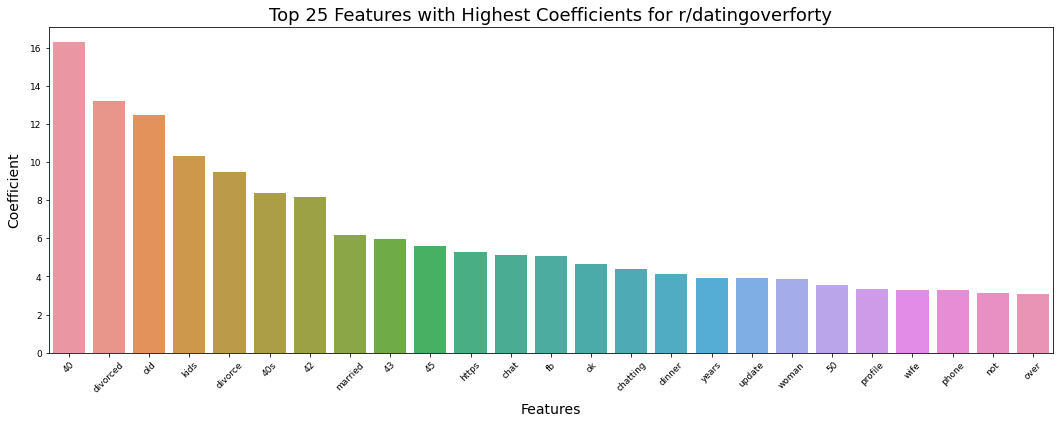

In [46]:
# Dataframe with 25 features with highest coefficients (corresponding with r/datingoverforty)
top_25 = coefficient_df.sort_values("coefficient", ascending=False).head(25)

# Plot bar chart
graph.my_barplot(top_25, "features", "coefficient", "Top 25 Features with Highest Coefficients for r/datingoverforty", size=18)

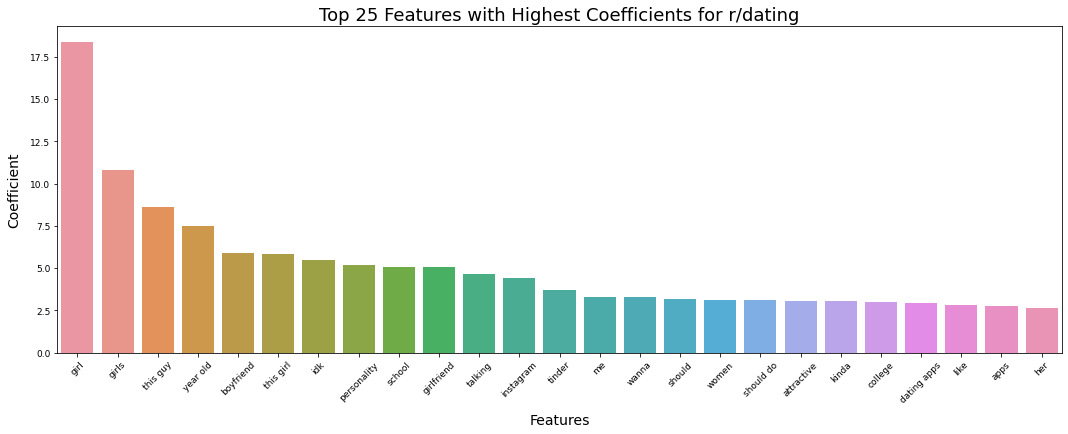

In [47]:
# Dataframe with 25 features with lowest coefficients (corresponding with subreddit class 0)
bottom_25 = coefficient_df.sort_values("coefficient", ascending=True).head(25)
bottom_25['coefficient'] = bottom_25['coefficient'].abs()

# Plot bar chart
graph.my_barplot(bottom_25, "features", "coefficient", "Top 25 Features with Highest Coefficients for r/dating", size=18)

In [17]:
coefficient_df.sort_values("coefficient", ascending=True).head(50)

,features,coefficient
1488,girl,-1.180572
1497,girls,-0.877019
4942,year old,-0.575822
4102,this guy,-0.573224
3146,personality,-0.430865
1495,girlfriend,-0.422514
646,boyfriend,-0.418976
1917,idk,-0.414166
4950,years old,-0.400068
824,college,-0.387021


## Feature Engineering

In [30]:
girl_re = "\Wgirl[A-Za-z]*"
marriage = "\Wmarr[A-Za-z]*"
common_number_suffixes = "hours|euros|hrs|inch|k|km|lb|lbs|min|mins|days|likes|mg \
|h|s|dd|pc|ppl|mph|ers|miles|mi|mimky|cm|oz|pounds|times|unread|bmi\
|cdn|am|pm" 
common_number_prefixes = "[$€£\s0-9]"
over_forty = f'\W[4-7][0-9](?!{common_number_suffixes})[A-Za-z]*'
under_forty = f'\W[2-3][0-9](?!{common_number_suffixes})[A-Za-z]*'
divorce = "\Wdivo[A-Za-z]+"
kids = "\Wkid|\Wchild|\Wchildren|\Wkids|\Wkiddo|\Wkiddos|\Wson|\Wdaughter"
all_ages_mf = '\W[1-7][0-9]|\W[1-7][0-9][MFmf]|\W[MFmf][1-7][0-9]'


over_forty2 = '\W[4-7][0-9]|\W[4-7][0-9][MFmfs]|\W[MFmf][4-7][0-9]'


thirty = '\W[3][0-9]|\W[3][0-9][MFmfs]|\W[MFmf][3][0-9]'
twenty = '\W[2][0-9]|\W[2][0-9][MFmfs]|\W[MFmf][2][0-9]'
school = "school|college|universi"

In [31]:
subreddit_df_copy = subreddit_df.copy()

subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(girl_re, " girl ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(marriage, " married ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(over_forty2, " 40 ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(thirty, " 20 ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(twenty, " 20 ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(divorce, " divorce ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(kids, " kids ", regex=True)
subreddit_df_copy['alltext'] = subreddit_df_copy['alltext'].str.replace(school, " school ", regex=True)

In [48]:
# Params for text vectorizer
export_vec_params = {
    "vec_type": "tfid",
    "stop_words": None,
    "max_features": 5000,
    "ngram_range": (1,3),
}

# Create dataframe
subreddit_df_copy = add_vectorized_to_df(subreddit_df_copy, "alltext", export_vec_params)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
subreddit_df_copy.to_csv("./data/final_processed.csv", index=False)

In [72]:
model_df_eda = model_df.drop(columns=["title", "selftext", "subreddit"])

In [35]:
add_stop_words = ["just", "like", "date", "dating", "ve", "want", 
                  "time", "relationship", "think", "feel", "people", 
                  "don", "really", "know", "said", "didn", "things",]

In [36]:
new_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [18]:
vec_params = {
    "vec_type": "count",
    "stop_words": "english",
    "max_features": 5000,
    "ngram_range": (1,4),
}

model_df_vec_target0 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 0], "alltext", vec_params)
model_df_vec_target1 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 1], "alltext", vec_params)

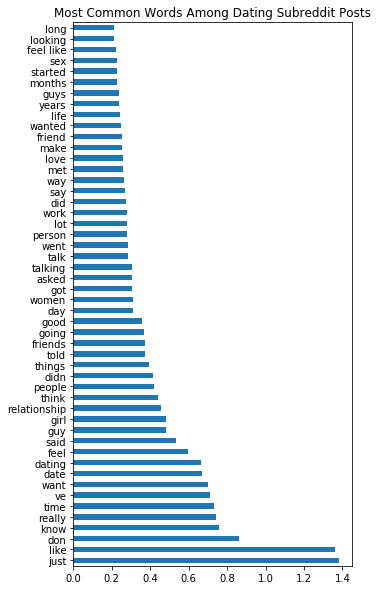

In [22]:
plt.figure(figsize=(5,10))
plt.title("Most Common Words Among Dating Subreddit Posts")
model_df_vec_target0.mean().sort_values(ascending=False).head(50).plot(kind="barh");

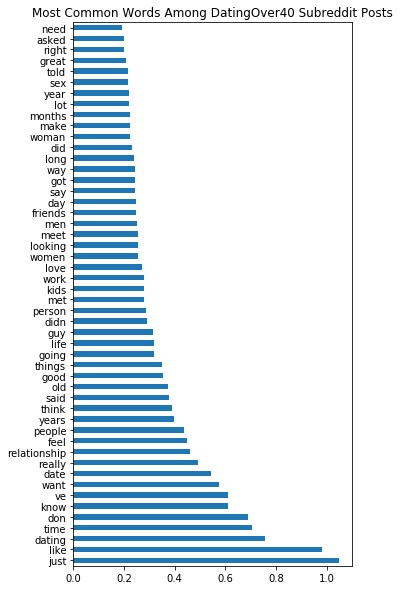

In [26]:
plt.figure(figsize=(5,10))
plt.title("Most Common Words Among DatingOver40 Subreddit Posts")
model_df_vec_target1.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

In [27]:
vec_params = {
    "vec_type": "tfid",
    "stop_words": "english",
    "max_features": 5000,
    "ngram_range": (1,4),
}

model_df_vec_target0 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 0], "alltext", vec_params)
model_df_vec_target1 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 1], "alltext", vec_params)

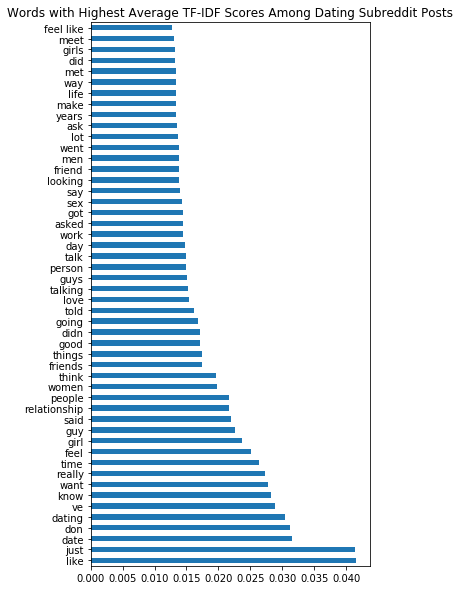

In [28]:
plt.figure(figsize=(5,10))
plt.title("Words with Highest Average TF-IDF Scores Among Dating Subreddit Posts")
model_df_vec_target0.mean().sort_values(ascending=False).head(50).plot(kind="barh");

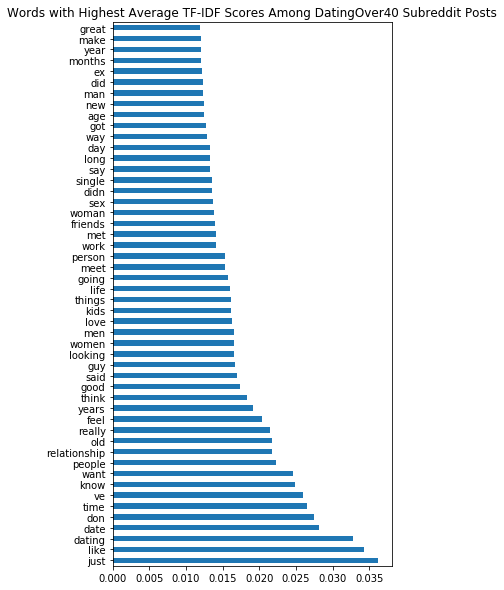

In [30]:
plt.figure(figsize=(5,10))
plt.title("Words with Highest Average TF-IDF Scores Among DatingOver40 Subreddit Posts")
model_df_vec_target1.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

In [37]:
vec_params = {
    "vec_type": "count",
    "stop_words": new_stop_words,
    "max_features": 5000,
    "ngram_range": (1,2),
}

model_df_vec_target0 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 0], "alltext", vec_params)
model_df_vec_target1 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 1], "alltext", vec_params)

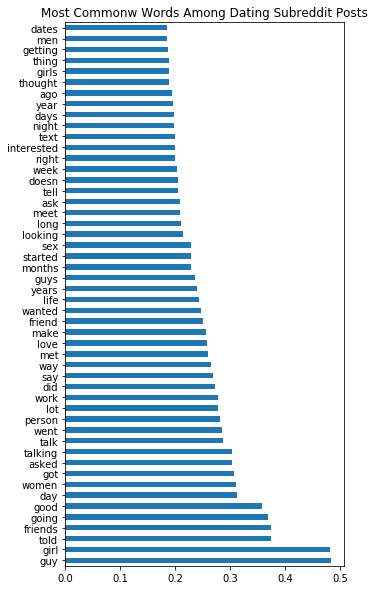

In [38]:
plt.figure(figsize=(5,10))
plt.title("Most Common Words Among Dating Subreddit Post")
model_df_vec_target0.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

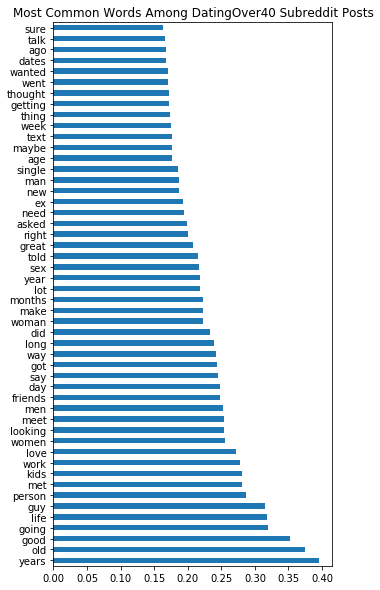

In [39]:
plt.figure(figsize=(5,10))
plt.title("Most Common Words Among DatingOver40 Subreddit Posts")
model_df_vec_target1.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

In [40]:
vec_params = {
    "vec_type": "tfid",
    "stop_words": new_stop_words,
    "max_features": 5000,
    "ngram_range": (1,4),
}

model_df_vec_target0 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 0], "alltext", vec_params)
model_df_vec_target1 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 1], "alltext", vec_params)

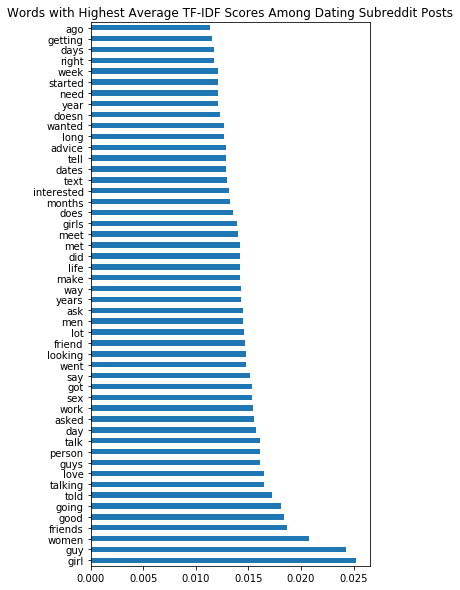

In [41]:
plt.figure(figsize=(5,10))
plt.title("Words with Highest Average TF-IDF Scores Among Dating Subreddit Posts")
model_df_vec_target0.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

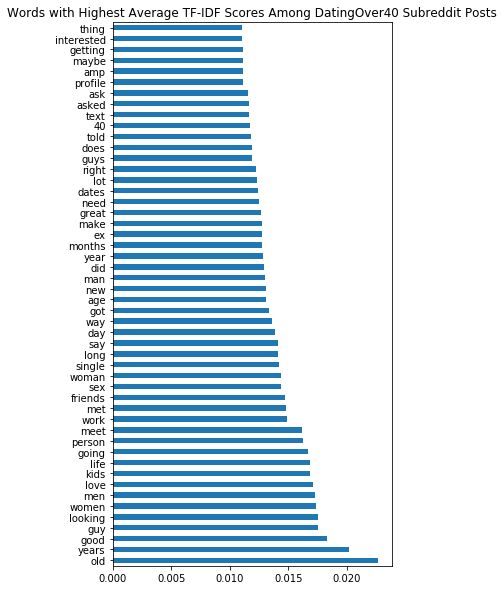

In [42]:
plt.figure(figsize=(5,10))
plt.title("Words with Highest Average TF-IDF Scores Among DatingOver40 Subreddit Posts")
model_df_vec_target1.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

In [78]:
vec_params = {
    "vec_type": "tfid",
    "stop_words": new_stop_words,
    "max_features": 5000,
    "ngram_range": (2,2),
}

model_df_vec_target0 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 0], "alltext", vec_params)
model_df_vec_target1 = add_vectorized_to_df(model_df_eda[model_df_eda['||__target__||'] == 1], "alltext", vec_params)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/var/folders/z5/c4rcrckn44b2pjl471gjcr8c0000gn/T/ipykernel_2836/646494962.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  model_df_vec_target0.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");


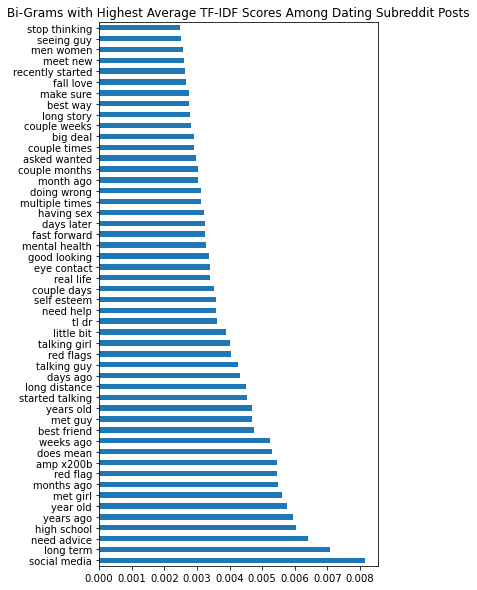

In [79]:
plt.figure(figsize=(5,10))
plt.title("Bi-Grams with Highest Average TF-IDF Scores Among Dating Subreddit Posts")
model_df_vec_target0.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

/var/folders/z5/c4rcrckn44b2pjl471gjcr8c0000gn/T/ipykernel_2836/1744255249.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  model_df_vec_target1.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");


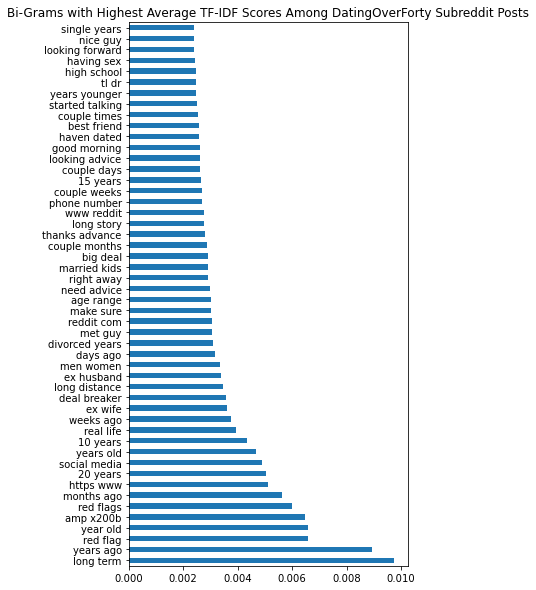

In [80]:
plt.figure(figsize=(5,10))
plt.title("Bi-Grams with Highest Average TF-IDF Scores Among DatingOverForty Subreddit Posts")
model_df_vec_target1.drop(columns=["||__target__||"]).mean().sort_values(ascending=False).head(50).plot(kind="barh");

In [255]:

girl_re = "\Wgirl[A-Za-z]*"
marriage = "\Wmarr[A-Za-z]*"
common_number_suffixes = "hours|euros|hrs|inch|k|km|lb|lbs|min|mins|days|likes|mg \
|h|s|dd|pc|ppl|mph|ers|miles|mi|mimky|cm|oz|pounds|times|unread|bmi\
|cdn|am|pm" 
common_number_prefixes = "[$€£\s0-9]"
over_forty = f'\W[4-7][0-9](?!{common_number_suffixes})[A-Za-z]*'
under_forty = f'\W[2-3][0-9](?!{common_number_suffixes})[A-Za-z]*'
divorce = "\Wdivo[A-Za-z]+"
kids = "\Wkid|\Wchild|\Wchildren|\Wkids|\Wkiddo|\Wkiddos|\Wson|\Wdaughter"
all_ages_mf = '\W[1-7][0-9]|\W[1-7][0-9][MFmf]|\W[MFmf][1-7][0-9]'
over_forty2 = '\W[4-7][0-9]|\W[4-7][0-9][MFmf]|\W[MFmf][4-7][0-9]'
thirty = '\W[3][0-9]|\W[3][0-9][MFmf]|\W[MFmf][3][0-9]'
twenty = '\W[2][0-9]|\W[2][0-9][MFmf]|\W[MFmf][2][0-9]'
school = "school|college|universi"
me_pronouns = "\W[I]|\Wme|\Wmy|\Wmine|\Wmyself"
male_pronouns = "\Whe|\Whim|\Whis|\Whimself"
female_pronouns = "\Wshe|\Wher|\Whers|\Wherself"
together_pronouns = "\Wwe|\Wus|\Wour|\Wours|\Wourselves|\Wthey|\Wthem|\Wtheir|\Wtheirs|\Wthemselves"

all_re_forty = [
#    girl_re,
    marriage,
    divorce,
    kids,
    over_forty2,
]

all_re_under = [
    girl_re,
    twenty,
    thirty,
    school
]


In [177]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [194]:
np.max([3,2,3,4])

4

In [210]:
model_df_vec_target0.columns[model_df_vec_target0.columns.str.contains(girl_re)]

Index(['advice girl', 'ago girl', 'amazing girl', 'approach girl',
       'approach girls', 'ask girl', 'ask girls', 'asked girl',
       'asked girlfriend', 'asking girl',
       ...
       'told girl', 'told girlfriend', 'type girl', 'virgin girls', 'way girl',
       'week girl', 'weird girl', 'went girl', 'women girl', 'work girl'],
      dtype='object', length=125)

In [211]:
model_df_vec_target1.columns[model_df_vec_target1.columns.str.contains(girl_re)]

Index(['boyfriend girlfriend', 'ex girlfriend', 'little girl',
       'live girlfriend', 'looking girl', 'met girl', 'new girl'],
      dtype='object')

In [179]:
target0_sentences = model_df_vec_target0['alltext'].apply(lambda x: sent_tokenize(x))

In [200]:
def average_words_per_sentence(sentences):
    return np.max([len(word_tokenize(sent)) for sent in sentences])
        
target0_sentences.apply(lambda x: average_words_per_sentence(x)).describe()

count    4584.000000
mean       44.232330
std        29.278977
min         5.000000
25%        28.000000
50%        38.000000
75%        52.000000
max       471.000000
Name: alltext, dtype: float64

In [201]:
target1_sentences = model_df_vec_target1['alltext'].apply(lambda x: sent_tokenize(x))
target1_sentences.apply(lambda x: average_words_per_sentence(x)).describe()

count    4584.000000
mean       39.056501
std        24.177747
min         2.000000
25%        26.000000
50%        35.000000
75%        46.000000
max       650.000000
Name: alltext, dtype: float64

In [256]:
print(model_df_vec_target0['alltext'].str.findall(over_forty).apply(lambda x: len(x)).sum())
print(model_df_vec_target1['alltext'].str.findall(over_forty).apply(lambda x: len(x)).sum())

228
2544


In [257]:
print(model_df_vec_target0['alltext'].str.findall(over_forty2).apply(lambda x: len(x)).sum())
print(model_df_vec_target1['alltext'].str.findall(over_forty2).apply(lambda x: len(x)).sum())

271
2908


In [259]:
over_forty3 = '\W[4-7][0-9]|\W[4-7][0-9][(]?[MFmf][)]?|\W[(]?[MFmf][)]?[4-7][0-9]'

print(model_df_vec_target0['alltext'].str.findall(over_forty3).apply(lambda x: len(x)).sum())
print(model_df_vec_target1['alltext'].str.findall(over_forty3).apply(lambda x: len(x)).sum())

271
2908


In [193]:

mask = pd.Series(False, index=model_df_vec_target0.index)

for regex in all_re_forty:
    mask = mask | model_df_vec_target1['alltext'].str.contains(regex, case=False)
    
#model_df_vec_target0['alltext'].str.contains(girl_re) | model_df_vec_target0['alltext'].str.contains(twenty)

mask.sum()/len(mask)


0.5530104712041884

In [ ]:
for text in list(model_df_vec_target1[~mask]['alltext']):
    print(text)
    print("**********")

## Experiments

In [1004]:
girl_re = "\Wgirl[A-Za-z]*"
marriage = "\Wmarr[A-Za-z]*"
common_number_suffixes = "hours|euros|hrs|inch|k|km|lb|lbs|min|mins|days|likes|mg \
|h|s|dd|pc|ppl|mph|ers|miles|mi|mimky|cm|oz|pounds|times|unread|bmi\
|cdn|am|pm" 
common_number_prefixes = "[$€£\s0-9]"
over_forty = f'\W[4-7][0-9](?!{common_number_suffixes})[A-Za-z]*'
under_forty = f'\W[2-3][0-9](?!{common_number_suffixes})[A-Za-z]*'
divorce = "\Wdivo[A-Za-z]+"
kids = "\Wkid|\Wchild|\Wchildren|\Wkids|\Wkiddo|\Wkiddos"
all_ages_mf = '\W[1-7][0-9]|\W[1-7][0-9][MFmf]|\W[MFmf][1-7][0-9]'

over_forty2 = '\W[4-7][0-9]|\W[4-7][0-9][MFmf]|\W[MFmf][4-7][0-9]'

thirty = '\W[3][0-9]|\W[3][0-9][MFmf]|\W[MFmf][3][0-9]'
twenty = '\W[2][0-9]|\W[2][0-9][MFmf]|\W[MFmf][2][0-9]'


In [25]:
girl_re = "\Wgirl[A-Za-z]*"
marriage = "\Wmarr[A-Za-z]*"
common_number_suffixes = "hours|euros|hrs|inch|k|km|lb|lbs|min|mins|days|likes|mg \
|h|s|dd|pc|ppl|mph|ers|miles|mi|mimky|cm|oz|pounds|times|unread|bmi\
|cdn|am|pm" 
common_number_prefixes = "[$€£\s0-9]"
over_forty = f'\W[4-7][0-9](?!{common_number_suffixes})[A-Za-z]*'
under_forty = f'\W[2-3][0-9](?!{common_number_suffixes})[A-Za-z]*'
divorce = "\Wdivo[A-Za-z]+"
kids = "\Wkid|\Wchild|\Wchildren|\Wkids|\Wkiddo|\Wkiddos|\Wson|\Wdaughter"
all_ages_mf = '\W[1-7][0-9]|\W[1-7][0-9][MFmf]|\W[MFmf][1-7][0-9]'


over_forty2 = '\W[4-7][0-9]|\W[4-7][0-9][MFmfs]|\W[MFmf][4-7][0-9]'


thirty = '\W[3][0-9]|\W[3][0-9][MFmfs]|\W[MFmf][3][0-9]'
twenty = '\W[2][0-9]|\W[2][0-9][MFmfs]|\W[MFmf][2][0-9]'
school = "school|college|universi"

In [26]:
model_df['alltext'] = model_df['alltext'].str.replace(girl_re, " girl ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(marriage, " married ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(over_forty2, " 40 ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(thirty, " 30 ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(twenty, " 20 ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(divorce, " divorce ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(kids, " kids ", regex=True)
model_df['alltext'] = model_df['alltext'].str.replace(school, " school ", regex=True)

NameError: name 'model_df' is not defined

In [987]:
experiment_re = all_ages_mf
experiment_df = model_df[model_df['alltext'].str.lower().str.contains(experiment_re, case=False)]

In [ ]:
# code from : https://stackoverflow.com/questions/33556050/efficient-concatenation-of-lists-in-pandas-series

set([x for list_ in experiment_df['alltext'].str.strip().str.lower().str.findall(experiment_re, flags=re.IGNORECASE).values for x in list_])

In [280]:
joe = TfidfVectorizer(max_features=5000)
joe.fit_transform(X)


<9168x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 905637 stored elements in Compressed Sparse Row format>

In [293]:
set([x for list_ in pd.Series(joe.get_feature_names()).str.findall("girl[A-Za-z]*").values for x in list_])

{'girl', 'girlfriend', 'girls'}

In [298]:
set([x for list_ in model_df['alltext'].str.findall(kids).values for x in list_])

{' kid'}

In [304]:
set([x for list_ in model_df_eda['alltext'].str.findall(over_forty2).values for x in list_])

{'\n40',
 '\n41',
 '\n43',
 '\n44',
 '\n45',
 '\n47',
 '\n50',
 '\n57',
 '\nF47',
 ' 40',
 ' 41',
 ' 42',
 ' 43',
 ' 44',
 ' 45',
 ' 46',
 ' 47',
 ' 48',
 ' 49',
 ' 50',
 ' 51',
 ' 52',
 ' 53',
 ' 54',
 ' 55',
 ' 56',
 ' 57',
 ' 58',
 ' 59',
 ' 60',
 ' 61',
 ' 62',
 ' 63',
 ' 64',
 ' 65',
 ' 67',
 ' 68',
 ' 70',
 ' 72',
 ' 73',
 ' 75',
 ' 76',
 ' 77',
 ' 78',
 ' 79',
 ' F40',
 ' F41',
 ' F43',
 ' F45',
 ' F48',
 ' F49',
 ' F50',
 ' M40',
 ' M41',
 ' M42',
 ' M45',
 ' M47',
 ' M48',
 ' M49',
 ' M50',
 ' M51',
 ' M52',
 ' M55',
 ' f45',
 ' m42',
 '$40',
 '$45',
 '$50',
 '$58',
 '$60',
 '$65',
 '$70',
 '$75',
 '(40',
 '(41',
 '(42',
 '(43',
 '(44',
 '(45',
 '(46',
 '(47',
 '(48',
 '(49',
 '(50',
 '(51',
 '(52',
 '(53',
 '(54',
 '(55',
 '(56',
 '(58',
 '(59',
 '(60',
 '(62',
 '(65',
 '(66',
 '(67',
 '(70',
 '(79',
 '(F40',
 '(F41',
 '(F42',
 '(F43',
 '(F44',
 '(F45',
 '(F46',
 '(F47',
 '(F49',
 '(F50',
 '(F51',
 '(F52',
 '(F55',
 '(F61',
 '(M40',
 '(M41',
 '(M43',
 '(M44',
 '(M45',
 '(M46'

## Create X and y

In [299]:
# Set X and y for modeling
X = model_df["alltext"]
y = model_df['||__target__||']

## Preprocessing/Feature Engineering

### Train Test Split

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Stemmer

In [ ]:
stemmer = PorterStemmer()

### Notes

- pass throughs
- notes
- new features?
- more data?
- eda?
- 

## Train Test Split

In [300]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Pipeline

In [301]:
# Set up pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

pipe = Pipeline([
    ("cvec", TfidfVectorizer()),
#    ("ss", StandardScaler()),
    ("ada", LogisticRegression(solver="liblinear", C=1)),
])

## GridSearchCV

In [306]:
# Set pipeline hyperparameters

add_stop_words = ["just", "like", "date", "dating", "ve", "want", 
                  "time", "relationship", "think", "feel", "people", 
                  "don", "really", "know", "said", "didn", "things",]
new_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

pipe_params = {
    "cvec__stop_words": ["english", new_stop_words],
#    "log__max_iter": [500,1000,1500,2000]
    "cvec__max_features": [5000, 6000, 7000],
    "cvec__ngram_range": [(1,3)],
    "cvec__binary": [False, True],
#    "log__penalty": ["l2"],
#    "log__solver": ["liblinear"],
#    "log__class_weight": ["balanced"],
#    "log__C": [.1],
}

# Instantiate and fit gridsearch
gs = GridSearchCV(pipe, pipe_params, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', TfidfVectorizer()),
                                       ('ada',
                                        LogisticRegression(C=1,
                                                           solver='liblinear'))]),
             param_grid={'cvec__binary': [False, True],
                         'cvec__max_features': [5000, 6000, 7000],
                         'cvec__ngram_range': [(1, 3)],
                         'cvec__stop_words': ['english',
                                              frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                   

In [215]:
gs.score(X_train, y_train)

0.9488074461896452

In [216]:
gs.score(X_test, y_test)

0.7993019197207679

In [305]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[["params", "mean_test_score"]]

,params,mean_test_score
5,"{'cvec__binary': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ('were', 'towards', 'whose', 'be', 'everything', 'he', 'meanwhile', 'her', 'though', 'there', 'h...",0.814572
7,"{'cvec__binary': True, 'cvec__max_features': 6000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ('were', 'towards', 'whose', 'be', 'everything', 'he', 'meanwhile', 'her', 'though', 'there', 'h...",0.813700
3,"{'cvec__binary': False, 'cvec__max_features': 6000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ('were', 'towards', 'whose', 'be', 'everything', 'he', 'meanwhile', 'her', 'though', 'there', '...",0.811955
1,"{'cvec__binary': False, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ('were', 'towards', 'whose', 'be', 'everything', 'he', 'meanwhile', 'her', 'though', 'there', '...",0.811664
6,"{'cvec__binary': True, 'cvec__max_features': 6000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}",0.809482
4,"{'cvec__binary': True, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}",0.808028
2,"{'cvec__binary': False, 'cvec__max_features': 6000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}",0.807301
0,"{'cvec__binary': False, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}",0.804392


In [908]:
gs.predict_proba(X_train.drop(columns="alltext"))

array([[0.2264719 , 0.7735281 ],
       [0.50413401, 0.49586599],
       [0.58462247, 0.41537753],
       ...,
       [0.44757077, 0.55242923],
       [0.67762318, 0.32237682],
       [0.50719319, 0.49280681]])

In [855]:
gs.coef_

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [272]:
log = LogisticRegression(solver='liblinear', penalty="l1", C=1)
log.fit(X_train, y_train)

ValueError: could not convert string to float: 'Best way to meet someone? Hello. I’m a 40 F and haven’t had a serious relationship in a while. I seem to meet men who want something casual and I’m not up for that. Does anyone know the best way to meet someone? And someone who would actually want a serious relationship verses something casual? I don’t sleep with men quickly and find the “third date” rule applies to many.'

In [1075]:
log.score(X_train, y_train)

0.8394415357766143

In [1076]:
log.score(X_test, y_test)

0.8089005235602095

In [1052]:
log.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [1065]:
coefficient_df = pd.DataFrame(list(zip(log.feature_names_in_, log.coef_[0])), columns=["features", "coefficient"]).sort_values("coefficient", ascending=False)

In [279]:
[x for x in gs.feature_names_in_ if "gir" in x]

AttributeError: 'GridSearchCV' object has no attribute 'feature_names_in_'

In [ ]:
[x for x in log.feature_names_in_ if "gir" in x]

In [862]:
[x for x in log.feature_names_in_ if "marr" in x]

['marriage', 'married']

In [863]:
[x for x in log.feature_names_in_ if "divo" in x]

['divorce', 'divorced']

In [864]:
[x for x in log.feature_names_in_ if "chil" in x]

['children', 'chill', 'chilling']

In [865]:
[x for x in log.feature_names_in_ if "kid" in x]

['kids']

In [866]:
import re
[x for x in log.feature_names_in_ if re.search('\A[1-3][0-9][A-Za-z]*\Z', x)]

['10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '18f',
 '18m',
 '19',
 '19f',
 '19m',
 '20',
 '20s',
 '21',
 '22',
 '25',
 '30',
 '30pm',
 '30s']

In [867]:
[x for x in log.feature_names_in_ if re.search('\A[4-9][0-9][A-Za-z]*\Z', x)]

['40', '40s', '50s', '80', '90', '95', '99']

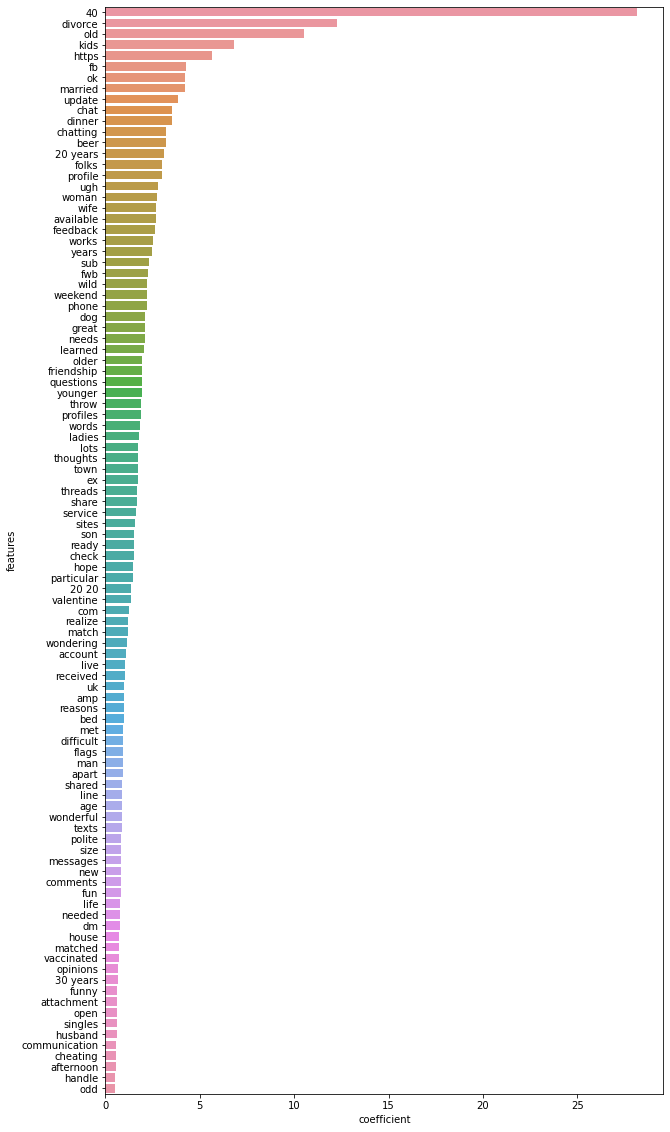

In [1066]:
plt.figure(figsize=(10, 20))
sns.barplot(y=coefficient_df.head(100)['features'], x=coefficient_df.head(100)['coefficient']);

In [909]:
probs = log.predict_proba(X_test.drop(columns="alltext"))

In [914]:
log.classes_

array([0, 1])

In [917]:
probs_df = pd.DataFrame(list(zip(X_test['alltext'], probs)))
probs_df["Under 40"] = probs_df[1].apply(lambda x: x[0])
probs_df["Over 40"] = probs_df[1].apply(lambda x: x[1])
probs_df["Class"] = y_test

In [ ]:
for x in list(probs_df.sort_values("Over 40", ascending=False).head(50)[0]):
    print(x)
    print("")
    print("******")
    print("")

NameError: name 'probs_df' is not defined

## Model Evaluation

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


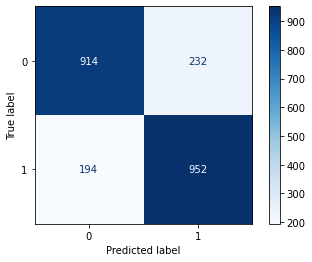

In [898]:
plot_confusion_matrix(gs, X_test.drop(columns="alltext"), y_test, cmap="Blues");

In [899]:
y_test_preds = gs.predict(X_test.drop(columns="alltext"))

In [900]:
false_positives = X_test[(y_test_preds != y_test) & (y_test == 0)]
false_negatives = X_test[(y_test_preds != y_test) & (y_test == 1)]

In [906]:
for text in list(false_positives['alltext']):
    print(text)
    print("")
    print("*************")
    print("")

How? How do I “love myself” I see myself and where I’m at in life and I’m nothing but disappointed. What are maybe some exercises or small things I can try and focus on to improve my mentality?

*************

Would this be a dealbreaker/red flag for you? I have ptsd and depression; while i know that i am loveable regardless, i also know that i lost several friends because of this...

(I am really not here for support, or anything; i just heard/red increasingly often that this is considered a red flag...)

I do know that this sub is definitely not representative, but i would like to know if this would be a dealbreaker/red flag for you (if you're comfortable maybe mention your gender)?

*************

Should I drop him as a “friend”? He’s backtracking after rejection. I’m feeling a bit mindf*cked today, but the blame is on both sides here tbh.

Soo, I recently got back in contact with an old friend after literally 10 years. We’ve never met, but we live in the same city and we once excha